# Übung zum numerischen Lösen linearer Gleichungssysteme

## Installation

⚠️ Achtung: Läuft nur mit jupyter notebook (nicht jupyter lab) ⚠️

Abhängigkeiten:

 - k3d:
     1. ```conda install -c conda-forge trimesh```
     2. ```conda install -c conda-forge k3d```
     3. ```jupyter nbextension install --py --sys-prefix k3d```
     4. ```jupyter nbextension enable --py --sys-prefix k3d```
     5. jupyter notebook neu starten

In [1]:
import numpy as np
from xyz_loader import read_wavefront
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets
import k3d
from scipy.spatial import KDTree
import time 
import trimesh
from tqdm import tqdm
from scipy.linalg import cho_factor, cho_solve
from matplotlib import pyplot as plt

## Anwendung im Bereich Geometry Processing

In dieser Übung soll ein 3D-Mesh "so starr wie möglich" deformiert werden. 

Ein trianguliertes Oberflächennetz (Mesh) kann durch eine Liste von $n$ Vertices $V = [[x_0.y_0.z_0],[x_1,y_1,z_1],\cdots,[x_{n-1}.y_{n-1}.z_{n-1}]]$ und einer Liste von Dreiecken beschrieben werden. 
Die Dreiecksliste $F$ = [[0,2,3],[3,5,8],...] verbindet 3 Vertices aus V. 
Die Indizes referenzieren den jeweiligen Vertex aus $V$.
    
Gegeben ist dabei ein Mesh in einer Ausgangsform. 
Zusätzlich werden interaktiv die Randbedingungen der Optimierung angegegeben. 
Dies geschieht durch manuelle Mausklicks auf dem Mesh. 
Vertices, die sich nicht bewegen dürfen, werden der Reihe nach ausgewählt. 
Der zuletzt gewählt Vertex wird auf eine vorgegebene Stelle im Raum gesetzt. 
Alle anderen Vertices sollen nun so starr wie möglich verschoben werden.

In dieser Aufgaben werden die folgenden Konzepte vertieft:
* Einführung in Geometry Processing. Viele Kozepte aus der Vorlesung werden in diesem Forschungsfeld anschaulich angewandt. 
* Implementierung und Verständnis von Kostenfunktionen.
* Aufstellen und Lösen linearer Gleichungssysteme.
* Eigenwertzerlegung, Singulärwertzerlegung.
    
In dieser Übung wird das Paper https://igl.ethz.ch/projects/ARAP/arap_web.pdf implementiert. Keine Sorge, ein Großteil des Verfahren ist hier bereits implementiert, es werden nur einzelne Teilprobleme von Ihnen gelöst.

Im ersten Schritt wird ein Mesh aus der beiliegenden Datei cow.obj geladen:

In [2]:
V,F = read_wavefront("cow.obj")
F[:] = F[:,[2,1,0]]
V[:] = V[:,[2,1,0]]

Ein zentraler Operator im Geometry Processing ist der Laplace-Beltrami Operator (LBO). Dieser kann mit einer Matrix $L$  mit $L \in \mathbb{R}^{n \times n}$ ausgedrückt werden. Der LBO lässt sich aus den Vertices $V$ und Dreiecken $F$ ermitteln. Neben dem LBO liefert die unten implementierte Funktion eine Gewichtsmatrix $W \in \mathbb{R}^{n \times n}$ zurück. Wir beschreiben einen Eintrag in der Matrix $W$ in Zeile $i$ und Spalte $j$ mit $w_{ij} \in \mathbb{R}$

Die Vorzeichen der LBO-Formulierung unterscheiden sich in den beiden genannten Quellen. Der Parameter ```sign``` konvertiert den LBO bei "-1" in die Darstellung für das Paper. 

In [3]:
#verts und faces entsprechen V und F im Text.
def lbo(verts,faces,sign):
    L = np.zeros([verts.shape[0],verts.shape[0]])
    W = np.zeros([verts.shape[0],verts.shape[0]])
    for f in faces:
        for i in range(3):
            j = (i+1) % 3
            p,q,o = f[i],f[j],f[(j+1) % 3]
            u = verts[o] - verts[p]
            v = verts[o] - verts[q]
            alpha = np.arccos(np.abs(np.inner(u,v))/
                (np.linalg.norm(u)*np.linalg.norm(v)))
            cot = .5*np.cos(alpha)/np.sin(alpha)
            W[p,q] -= cot
            W[q,p] -= cot
            L[p,p] -= cot
            L[p,q] += cot
            L[q,q] -= cot
            L[q,p] += cot
    return sign*L,sign*W

# Die Kostenfunktion

Bei einem gegebenen Mesh mit vertices $V$ und Dreiecken $F$ werden modifizierte Vertexpositionen $V' \in \mathbb{R}^{n \times 3}$ gesucht. 
Einzelne Zeilen aus $V$ und $V'$ schreiben wir als $v_i,v'_i \in \mathbb{R}^3$, wobei $i$ die Zeilen indiziert.
Dabei gibt der User einige Zeilen aus $V'$ fest vor (diese entsprechen den ausgewählten Punkten in der 3D Ansicht). 
Die Übrigen Zeilen werden durch Minimierung einer Kostenfuntion bestimmt.
Neben den zu optimierenden Parametern $V'$ werden zusätzliche Parameter eingeführt.
Für jeden Vertex wird eine Rotationsmatrix $R_i \in \mathbb{R}^{3 \times 3}$ eingeführt, also insgesammt $n$ zusätzliche unbekannte Rotationsmatrizen.

Bevor wir die zu minimierende Kostenfunktion definieren können, benötigen wir noch eine Definition der Nachbarschaft eines Vertex. 
Zwei Vertices sind Nachbarn, wenn sich im Mesh durch eine Kante verbunden sind. 
Wir notieren die Nachbarschaft des mit $i$ indizieren Vertex mit $\mathcal{N}(i)$. 
Wenn die Vertices, die mit $i$ und $j$ indiziert sind Nachbarn sind, dann gilt $j \in \mathcal{N}(i)$ und $i \in \mathcal{N}(j)$, andernfalls gilt $j \notin \mathcal{N}(i)$ und $i \notin \mathcal{N}(j)$. 
Glücklicherwiese können Sie die Nachbarschaftsbeziehung aus der oben eingeführten Gewichtsmatrix $W$ ableiten.
Es gilt $w_{ij} \neq 0 \iff j \in \mathcal{N}(i)$. 

Jetzt haben wir alle Komponenten, um die Kostenfunktion $E$ definieren zu können mit

\begin{equation}
E(V',R_1,R_2,\cdots,R_n) = \sum_{i=1}^N  \sum_{j \in \mathcal{N}(i)} w_{ij} ||v'_i-v'_j - R_i(v_i-v_j)||_2^2 \tag{1}
\end{equation}

## Aufgabe 1

Implementieren Sie die Kostenfunktion (1). 

```W``` is die Gewichtematrix, $R=[R_1,R_2,\cdots,R_n]$ ist eine Liste von Rotationsmatrizen, ```verts``` entspricht $V$ und ```vertsP``` entspricht $V'$. 

Können Sie die Kostenfunktion in eigenen Worten beschreiben?

In [4]:
def E(W,R,verts,vertsP):
    error = 0
    for i in range(verts.shape[0]):
        nonzeros = np.where(W[i,:])[0]
        for j in nonzeros:
            dev = vertsP[i]- vertsP[j] - R[i].dot(verts[i]-verts[j])
            error += W[i,j] * np.inner(dev,dev)
    return error

## Aufgabe 2

In diesem Abschnitt lernen wir den LBO besser kennen. Zerlegen Sie den LBO in Eigenwerte ```Le``` und Eigenvektoren ```Lv```. Sortieren Sie die Eigenvektoren aufsteigend entsprechend der Eigenwerte. (Tipp: Hier können Funktionen aus dem ```linalg```-Modul von Numpy hilfreich sein.)

Was können Sie über die Definitheit und die Symmetrieeigenschaften des LBOs aussagen?

In [5]:
?np.linalg.eig
L,_ = lbo(V,F,-1)
Le, Lv = np.linalg.eig(L)
idx = Le.argsort()
Le = Le[idx]
Lv = Lv[:,idx]
print(Le)

[-4.36910017e-15  2.51607186e-03  9.50359568e-03 ...  1.68289878e+01
  1.80694918e+01  1.80698632e+01]


## Aufgabe 3

Weisen Sie k3meshspec.attribute unterschiedliche Eigenvektoren mit Hilfe des Sliders zu. 

Was fällt Ihnen auf? Sie können den Slider auch mit den Pfeiltasten steuern.

In [6]:
C = .5*np.ones(V.shape[0],dtype=np.float32)
k3meshplotspec_eigenvectors = k3d.plot()
k3meshspec_eigenvectors = k3d.mesh(V,F,attribute=C,color_map=k3d.basic_color_maps.Jet, color_range=[0.0, 1.0])
k3meshplotspec_eigenvectors += k3meshspec_eigenvectors
k3meshplotspec_eigenvectors.display()

/home/samuel/anaconda3/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/home/samuel/anaconda3/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

In [7]:
def eigenvector_callback(x):
    vis = Lv[:,x].copy()  
    vis = (vis-vis.mean()) / (2*vis.std()) + .5
    k3meshspec_eigenvectors.attribute = vis.astype(np.float32)
interact(eigenvector_callback, x=widgets.IntSlider(min=0, max=V.shape[0]-1, step=1, value=50));


interactive(children=(IntSlider(value=50, description='x', max=2929), Output()), _dom_classes=('widget-interac…

## Aufgabe 4
Fassen Sie den LBO als Kovarianzmatrix auf und "komprimieren" Sie die 3D-Form durch Dimensionsreduktion der Vertexpositionen (PCA ohne Zentrierung). 

Nutzen Sie den Slider, um die Anzahl der Hauptkomponenten zu regeln. Wie wirkt sich die Stellung des Sliders auf die Kompression des Meshes aus?

In [8]:
k3meshplotspec_pca = k3d.plot()
k3meshspec_pca = k3d.mesh(V,F,attribute=C,color_map=k3d.basic_color_maps.Jet, color_range=[0.0, 1.0])
k3meshplotspec_pca += k3meshspec_pca
k3meshplotspec_pca.display()

Output()

In [9]:
def eigenvector_callback(x):
    V3 = []
    neigs = x #Modfifizieren
    for i in range(3):
        C1 = Lv.T.dot(V[:,i])[:neigs]
        V1 = Lv[:,:neigs].dot(C1).reshape(-1,1)
        V3.append(V1)
    V3 = np.hstack(V3).astype(np.float32)
    k3meshspec_pca.vertices = V3
interact(eigenvector_callback, x=widgets.IntSlider(min=0, max=V.shape[0]-1, step=1, value=30));

interactive(children=(IntSlider(value=30, description='x', max=2929), Output()), _dom_classes=('widget-interac…

# Minimierung der Kostenfunktion

Wie Sie vielleicht schon erkannt haben, handelt es sich bei der Minimierung von (1) um ein nichtlineares least-sqaures Problem. Dies könnten Sie mit Hilfe von Gauss-Newton oder Levenberg-Marquardt lösen:

\begin{equation}
\hat{V}',\hat{R}_1,\hat{R}_2,\cdots,\hat{R}_n = \underset{V',R_1,R_2,\cdots,R_n}{\operatorname{argmin}} E(V',R_1,R_2,\cdots,R_n) \tag{2}
\end{equation}

Stattdessen minimieren wir hier die Kostenfunktion mit Hilfe eines alternierenden Optimierungsverfahrens. Ausgehend von einer initialen Schätzung der Parameter $V'^{(0)} = V$ suchen wir iterativ besser geeignete Parameter. Dabei minimieren wir abwechselnd

\begin{equation}
R_1^{(k+1)},R_2^{(k+1)},\cdots,R_n^{(k+1)} = \underset{R_1,R_2,\cdots,R_n}{\operatorname{argmin}} E(V'^{(k)},R_1,R_2,\cdots,R_n) \tag{3}
\end{equation}

und

\begin{equation}
V'^{(k+1)} = \underset{V'}{\operatorname{argmin}} E(V',R_1^{(k+1)},R_2^{(k+1)},\cdots,R_n^{(k+1)}) \tag{4}
\end{equation}

Im Gegensatz zu (2) lassen sich (3) und (4) in einer geschlossenen Form lösen. Der Optimierungsschritt (3) ist bereits implementiert, lediglich (4) ist noch zu programmieren. Partielles Ableiten nach allen Einträgen aus $V'$ und anschließendes Nullsetzen liefert die drei separierbaren linearen Gleichungssysteme

\begin{align}
L v_x^{'(k)} &= b_x^{(k)} \\
L v_y^{'(k)} &= b_y^{(k)} \tag{5} \\
L v_z^{'(k)} &= b_z^{(k)}, \\
\end{align}

wobei $L$ der LBO ist, $[v_x^{'(k)}, v_y^{'(k)}, v_z^{'(k)}]=V^{'(k)}$ die drei Spalten von $V'^{(k)}$ indiziert, $[ b_x^{(k)}, b_y^{(k)}, b_z^{(k)}] = B^{(k)}$ mit $B^{(k)} \in \mathbb{R}^{n \times 3}$ und die $i$-te Zeile von $B^{(k)}$ definiert ist mit

\begin{equation}
b_i^{(k)} = \sum_{j \in \mathcal{N}(I)} \frac{w_{ij}}{2} (R_i^{(k)}+R_j^{(k)})(v_i-v_j). \tag{5}
\end{equation}

## Aufgabe 5

Implementieren Sie die rechte Seite von (5). 

Vervollständigen Sie die Funktion ```rhs``` mit den Gewichten $W$, der Liste an Rotationsmatrizen  $R=[R_1,R_2,\cdots,R_n]$ und den initialen Vertexpositionen $V$ (```verts```).

In [10]:
def rhs(W,Rs,verts):
    B_all = []
    for i in range(verts.shape[0]):
        Ri = Rs[i]
        nonzeros = np.where(W[i,:])[0]
        Bj = np.zeros(3,dtype=np.float64)
        for j in nonzeros:
            Bj += .5*W[i,j]*(Ri+Rs[j]) @ (verts[i]-verts[j])
        B_all.append(Bj)
    return np.vstack(B_all)

Die Routine zum Lösen von (3) wurde hier bereits implementiert und liefert die entsprechenden Rotationsmatrizen zurück:

In [11]:
def solve_Rs(verts,vertsP,faces,W):
    Rs = []
    for i in range(verts.shape[0]):
        nonzeros = np.where(W[i,:])[0]
        D = np.diag(W[i,nonzeros])
        E = verts[i] - verts[nonzeros]
        EP = vertsP[i] - vertsP[nonzeros]
        S = E.T.dot(D).dot(EP)
        svd_u,svd_sig,svd_v = np.linalg.svd(S)
        R = svd_v.T.dot(svd_u.T)
        if np.linalg.det(R) < 0:
            svd_u[:,2] *= -1
            R = svd_v.T.dot(svd_u.T)
        assert( np.linalg.det(R) > 0 )
        Rs.append(R)
    return Rs

## Aufgabe 6

Vervollständigen Sie die Implementierung des alternierenden Optimierungsverfahrens. 

Die Routine ```solve_arap``` bekommt als Parameter die Liste der Vertexindizes, welche auf feste Zielpositionen gesetzt werden. Dabei werden die spezifizierten Vertices auf ihre ursprüngliche Position gesetzt. Lediglich der letzte spezifizierte Vertex wird auf die Position ```target_point``` gesetzt.

### Aufgabe 6a
Modifizien sie den LBO $L$ und $B$, sodass das Gleichungssystem die vorgegebenen Constraints einhält.

### Aufgabe 6b
Das Gleichungssystem wird aktuell in jeder Iteration von Grund auf neu gelöst, obwohl die Systemmatrix $L$ konstant ist. Nutzen Sie eine passende Faktorisierungsmethode, um die Performance des Verfahrens zu verbessern. 

Hinweis: Der modifizierte LBO ist immer symmetrisch, positiv definit. 
Welche Faktorisierungmethode bietet sich daher an? Im Paket ```scipy.linalg``` finden Sie eine Sammlung an Matrixfaktorisierungsverfahren.

100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


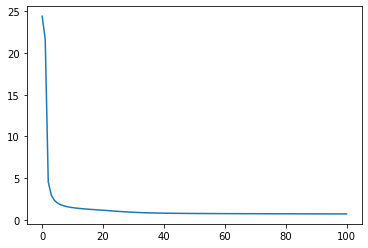

In [12]:
n_iterations = 50
def solve_arap(fixed_vertex_indices=[289,577,2212, 284], target_point = np.array([1,-1.1,0])):
    LInit,W = lbo(V,F,-1)
    vnew = V[fixed_vertex_indices]
    vnew[-1] = target_point
    Rs = [np.eye(3) for i in range(V.shape[0])]
    vertices_history = []
    error_history = []
    vertices_history.append(V)
    
    U = V.copy()
    U[fixed_vertex_indices[-1]] = target_point
    error_history.append(E(W,Rs,V,U))
    L = LInit.copy()
    
    #### Lösung Aufgabe 6a
    L[:,fixed_vertex_indices] = 0
    L[fixed_vertex_indices,:] = 0
    L[fixed_vertex_indices,fixed_vertex_indices] = 1
    #### Lösung Aufgabe 6a
    
    factor = cho_factor(L) #Aufgabe 6b
    
    for i in tqdm(range(n_iterations)):
        Rs = solve_Rs(V,U,F,W)
        error_history.append(E(W,Rs,V,U))
        B = rhs(W,Rs,V)
        ### Lösung 6a
        B -= LInit[:,fixed_vertex_indices].dot(vnew)
        B[fixed_vertex_indices] = vnew      
        ### Lösung 6a
        #U = np.linalg.solve(L,B) #Aufgabe 6b
        U = cho_solve(factor,B) #Aufgabe 6b  
        error_history.append(E(W,Rs,V,U))
        vertices_history.append(U)
    return vertices_history,error_history
history,errors, = solve_arap()
plt.plot(errors)

## Aufgabe 7

Visualisieren Sie den Fortschritt Ihres Verfahren mit Hilfe des Sliders:

In [13]:
k3meshplotspec_arap = k3d.plot()
k3meshspec_arap = k3d.mesh(V,F,attribute=C,color_map=k3d.basic_color_maps.Jet, color_range=[0.0, 1.0])
k3meshplotspec_arap += k3meshspec_arap
k3meshplotspec_arap.display()

Output()

In [14]:
def history_callback(i):    
    k3meshspec_arap.vertices = history[i] 
interact(history_callback, i=widgets.IntSlider(min=0, max=n_iterations, step=1, value=0));

interactive(children=(IntSlider(value=0, description='i', max=50), Output()), _dom_classes=('widget-interact',…

# Interaktive Segmentierung

Die nächste Zelle implementiert die interaktive Segmentierung des 3D-Modells. Die Anleitung zur Segmentierung finden Sie weiter unten.

In [15]:
meshSpans = V.max(axis=0) - V.min(axis=0)
C = .5*np.ones(V.shape[0],dtype=np.float32)

mesh = trimesh.Trimesh(vertices=V,
                       faces=F)
pitch = 0.02
voxels = mesh.voxelized(pitch=pitch).matrix

origin = V.min(axis=0)
origin[2] = V[:,2].max()
meshSpanY = V[:,1].max() - V[:,1].min()
voxelSpanY = voxels.shape[1]

tree = KDTree(V)

k3mesh = k3d.mesh(V,F,attribute=C,color_map=k3d.basic_color_maps.Jet, color_range=[0.0, 1.0])

clicks = []

def on_click(x, y, z):
    query_pt = np.array([[z,y,-x]])
    query_pt = query_pt* (meshSpanY/ voxelSpanY) + origin
    
    vidx = tree.query(query_pt)[1][0]
    cpy = k3mesh.attribute.copy()
    cpy[clicks] = 0.0
    cpy[vidx] = 1.0
    k3mesh.attribute = cpy
    time.sleep(0.05)
    clicks.append(vidx)

color_map = (0x00ff00, 0xff0000, 0x00ff00)
obj = k3d.voxels(voxels.astype(np.uint8), color_map)
plot = k3d.plot()
plot += obj

obj.click_callback = on_click
plot.voxel_paint_color = 0
plot.mode = 'callback'
plot.display()

/home/samuel/anaconda3/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/home/samuel/anaconda3/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

# 3D Viewer
## Aufgabe 7

Wählen Sie im 3D-View oben Control->Mode-Callbacks und klicken Sie auf das Mesh um Nebenbedigungen zu setzen. Das Resultat ist in der View unten zu sehen. Grün = "freie Vertices", blau = "feste Vertices" und rot = "fester, im Code gesetzter Vertex".

In [16]:
k3meshplot = k3d.plot()
k3meshplot += k3mesh
k3meshplot.display()
k3meshplot.camera_auto_fit = False

Output()

In [17]:
attr = k3mesh.attribute.copy()
fix = np.where(attr < 0.001)[0]
fix = np.concatenate([fix,np.where(attr > 0.99)[0]])
history_interactive,errors_interactive, = solve_arap(fix,np.array([1,-1.1,0]))
plt.plot(errors_interactive)
def history_interactive_callback(i):    
    k3mesh.vertices = history_interactive[i] 
interact(history_interactive_callback, i=widgets.IntSlider(min=0, max=n_iterations, step=1, value=0));

IndexError: index -1 is out of bounds for axis 0 with size 0